In [1]:
import os
import sys
print("nihao")
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Add src to the system path
if src_path not in sys.path:
    sys.path.insert(0, src_path)

    
from matplotlib import pyplot as plt

import torch
import numpy as np

from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
import schnetpack.transform as trn
from schnetpack.datasets import QM9

from morered.datasets import QM9Filtered
from morered.noise_schedules import CosineSchedule, PolynomialSchedule, LinearSchedule
from morered.processes import VPGaussianDDPM
from morered.transform import Diffuse
from morered.utils import scatter_mean
print("hey")

nihao
hey


In [2]:
print(QM9Filtered)
print(CosineSchedule, PolynomialSchedule, LinearSchedule)
print(VPGaussianDDPM)
print(Diffuse)
print(scatter_mean)


<class 'morered.datasets.qm9_filtered.QM9Filtered'>
<class 'morered.noise_schedules.CosineSchedule'> <class 'morered.noise_schedules.PolynomialSchedule'> <class 'morered.noise_schedules.LinearSchedule'>
<class 'morered.processes.Gaussian.VPGaussianDDPM'>
<class 'morered.transform.transforms.Diffuse'>
<function scatter_mean at 0x7f99466b2430>


# Prepare the data

In [3]:
# MAIN

def print_current_directory_info():
    cwd = os.getcwd()
    print(f"\n📁 Current working directory: {cwd}")
    print("📂 Contents of current directory:")
    for entry in os.listdir(cwd):
        print(f"  - {entry}")
    print()

def print_data(data_dir):
    if not os.path.exists(data_dir):
        print(f"[!] Directory not found: {data_dir}")
        return

    print(f"\n🔍 Reading data from: {data_dir}")
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        if os.path.isfile(file_path):
            print(f"  - {file}")


print_current_directory_info()

# Absolute path inside container to the mounted dataset
dataset_path = "/input-data/energy_U0"

print("--- CONTENTS OF QM9 DATASET DIR ---")
print_data(dataset_path)



📁 Current working directory: /home/svenelzes/MoreRed/notebooks
📂 Contents of current directory:
  - diffusion_tutorial.ipynb
  - denoising_tutorial.ipynb
  - .ipynb_checkpoints
  - splitting.lock

--- CONTENTS OF QM9 DATASET DIR ---

🔍 Reading data from: /input-data/energy_U0
  - qm9.db
  - split.npz


Define paths

In [4]:
#tut_path = "./tut" deprecated
#our dataset is in hydra temp folder.

# Absolute path inside container to the mounted dataset
dataset_path = "/input-data/energy_U0"
# path to store the dataset as ASE '.db' files
datapath = os.path.join(dataset_path, "qm9.db") 

# path to store the dataset as ASE '.db' files
split_file_path = os.path.join(dataset_path, "split.npz") 

# path to store a mapping between the DB indices and the number of atoms. Needed for filtered loading from the dataset
indices_path = os.path.join(dataset_path, "n_atoms_indices.pkl") 

In [5]:
from ase.db import connect

db_path = os.path.join(dataset_path, "qm9.db")
db = connect(db_path)

# Check how many entries
print(f"Number of entries: {len(db)}")

# Peek at the first entry
row = db[1]  # ASE DB is 1-indexed
print(row)   # summary
atoms = row.toatoms()
print(atoms)  # full atomic structure

# You can also list available keys/properties
print(row.key_value_pairs)


Number of entries: 133885
<AtomsRow: formula=CH4, keys=>
Atoms(symbols='CH4', pbc=False)
{}


In [8]:
import numpy as np

split_path = os.path.join(dataset_path, "split.npz")
data = np.load(split_path)

# List all arrays stored inside
print(data.files)

# Inspect each
for key in data.files:
    arr = data[key]
    print(f"{key}: shape={arr.shape}, dtype={arr.dtype}")
data["train_idx"][0:10]

['train_idx', 'val_idx', 'test_idx']
train_idx: shape=(100000,), dtype=int64
val_idx: shape=(1000,), dtype=int64
test_idx: shape=(32885,), dtype=int64


array([100094,   8930,  35477, 109919,  27381, 103975,  93886,  35920,
         4444, 132821])

In [11]:
os.makedirs(dataset_path, exist_ok=True)

Define data input transformations

In [9]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
]

Define dataset and dataloaders

In [10]:
qm9data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    n_atoms_allowed=None,
    shuffle_train=True,
    n_overfit_molecules=None,
    permute_indices=False,
    repeat_indices=None,
    remove_uncharacterized=False, #True
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    property_units={QM9.U0: 'eV'},
    num_workers=2,
    split_file=split_file_path,
    indices_path=indices_path,
    pin_memory=False,
    load_properties=[QM9.U0]
)

In [14]:
# prepare and setup the dataset
qm9data.prepare_data()
qm9data.setup()

Load and plot an example batch

In [15]:
batch = next(iter(qm9data.train_dataloader()))

In [16]:
batch.keys()

dict_keys(['_idx', 'energy_U0', '_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', '_idx_m'])

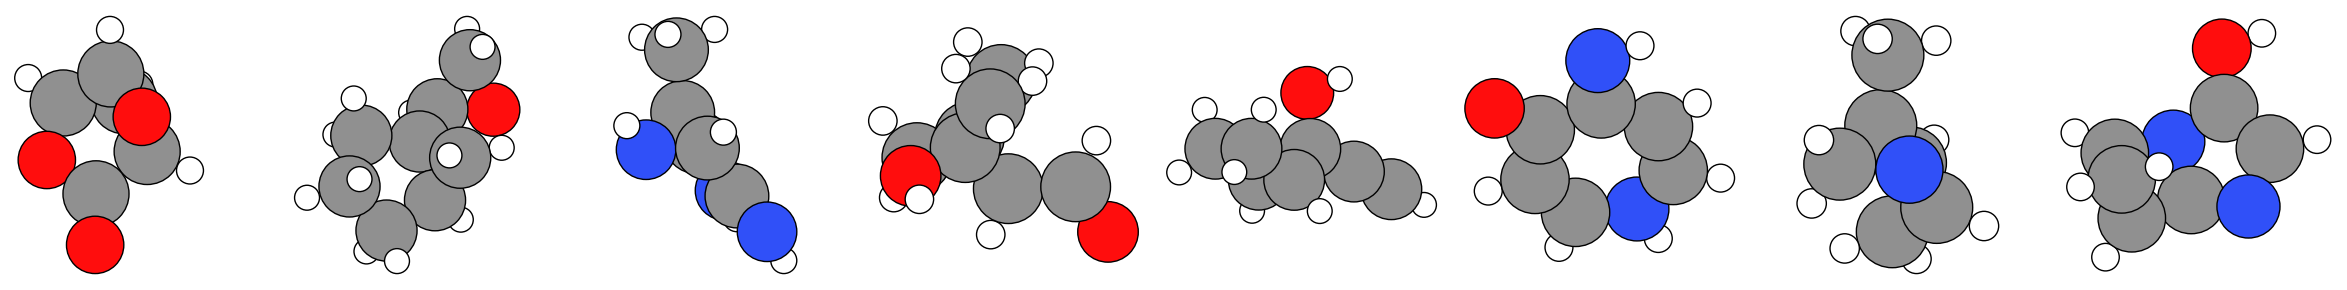

In [17]:
n_cols = 8
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    mask = batch[properties.idx_m] == i
    mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

    plot_atoms(mol, ax, rotation=("0x,0y,0z"))
    ax.axis("off")

plt.tight_layout()
plt.show()

# Noise Schedules

Define example schedules

In [18]:
# define the noise schedules 
polynomial_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")
cosine_schedule = CosineSchedule(T=1000, s=0.008, v=1., variance_type="lower_bound")
cosine_schedule_vignac = CosineSchedule(T=1000, s=0.008, v=2.5, variance_type="lower_bound")
linear_schedule = LinearSchedule(T=1000, variance_type="lower_bound")

step = 10
x = np.arange(0, polynomial_schedule.T, step)

Plot the schedules

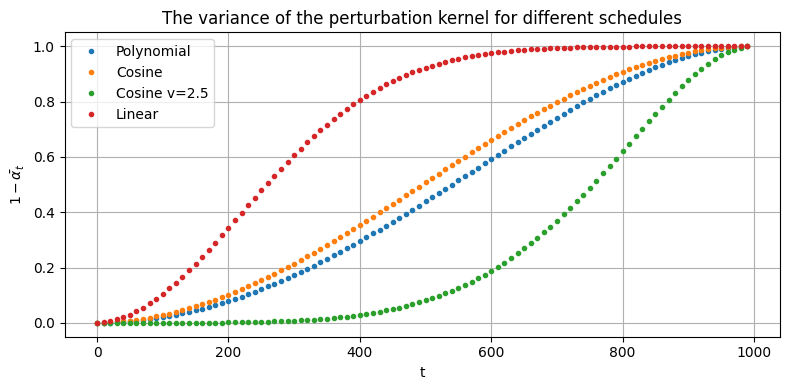

In [19]:
plt.figure(figsize=(8, 4))

plt.plot(x, polynomial_schedule.betas_bar[::step], '.', label="Polynomial")
plt.plot(x, cosine_schedule.betas_bar[::step], '.', label="Cosine")
plt.plot(x, cosine_schedule_vignac.betas_bar[::step], '.', label="Cosine v=2.5")
plt.plot(x, linear_schedule.betas_bar[::step], '.', label="Linear")

plt.xlabel(r"t")
plt.ylabel(r"$1-\bar{\alpha_t}$")
plt.title("The variance of the perturbation kernel for different schedules")

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

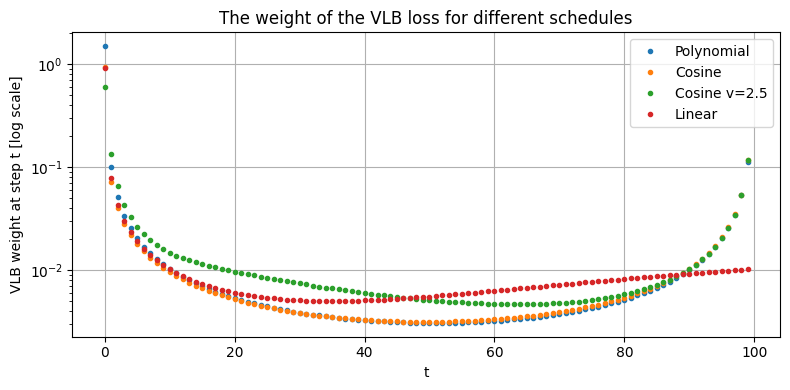

In [12]:
# plot the vlb weight for all schedules
plt.figure(figsize=(8, 4))

plt.plot(polynomial_schedule.vlb_weights[::step], '.', label="Polynomial")
plt.plot(cosine_schedule.vlb_weights[::step], '.', label="Cosine")
plt.plot(cosine_schedule_vignac.vlb_weights[::step], '.', label="Cosine v=2.5")
plt.plot(linear_schedule.vlb_weights[::step], '.', label="Linear")

plt.yscale("log")

plt.xlabel("t")
plt.ylabel("VLB weight at step t [log scale]")
plt.title("The weight of the VLB loss for different schedules")

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Variance-Preserving Gaussian diffusion

Define the diffusion process

In [20]:
# define the noise schedule
noise_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
ddpm = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

Simulate the forward trajectory for one example molecule

In [39]:
# fetch an example molecule
mol = qm9data.train_dataset[5]
x = mol[properties.R]
print(properties.R)
# Get the whole diffusion trajectory
timesteps = torch.arange(1000).unsqueeze(-1).unsqueeze(-1)
x_t, noise = ddpm.diffuse(x, None, timesteps)

x_t.shape, noise.shape

_positions


(torch.Size([1000, 22, 3]), torch.Size([1000, 22, 3]))

In [22]:
# check if the centre of geometry for the molecule and noise is zero
assert (x_t.mean(-2) < 1e-15).all() and (noise.mean(-2) < 1e-15).all()

plot the diffusion trajectory

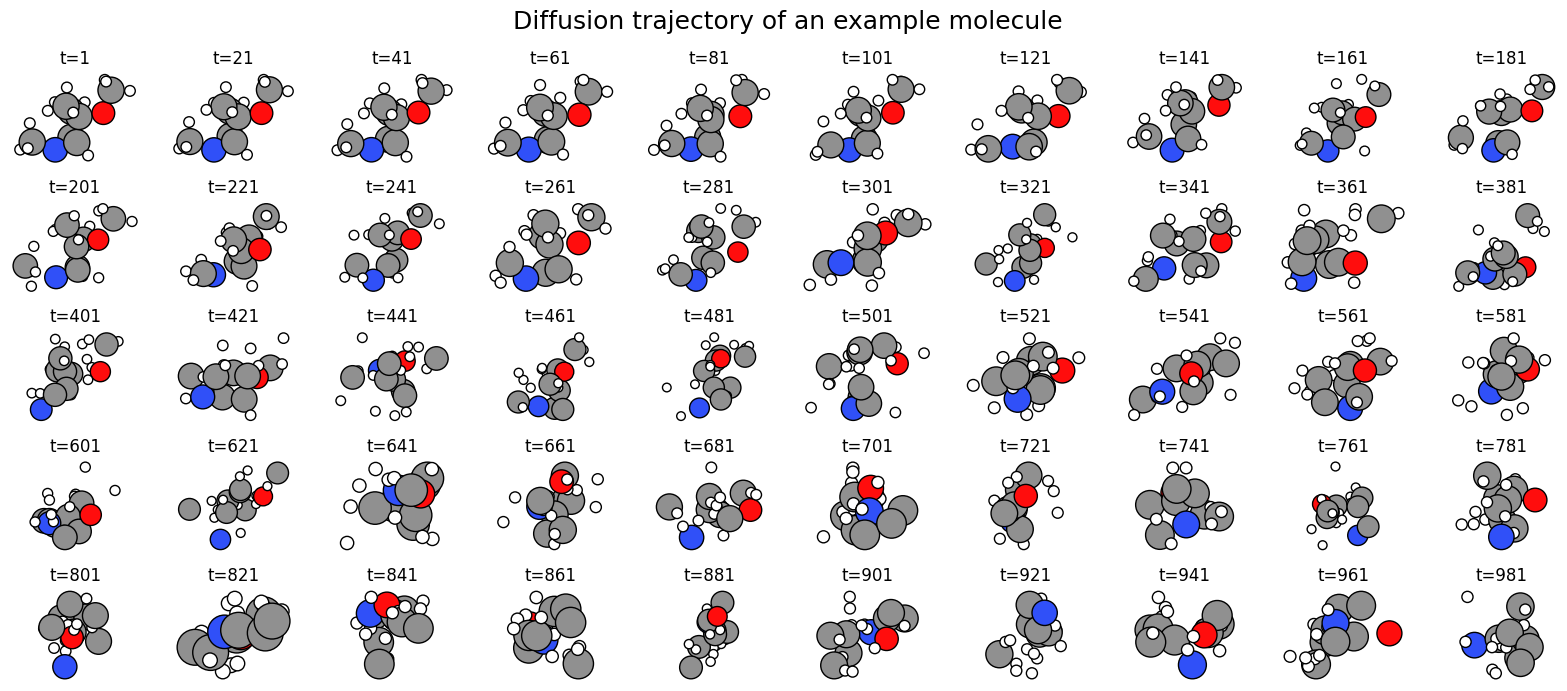

In [23]:
fig, axs = plt.subplots(5, 10, figsize=(16, 7))
axs = axs.flatten()

for i, t in enumerate(range(0,1000,20)):
    diffused_R = x_t[t]
    Z = mol[properties.Z]
    m = Atoms(positions=diffused_R, numbers=Z)
    
    plot_atoms(m, ax=axs[i])
    axs[i].axis("off")
    axs[i].set_title(f"t={t+1}")

plt.suptitle("Diffusion trajectory of an example molecule", fontsize=18)
plt.tight_layout()
plt.show()

# Diffusion as input transformation for data loader

Redefine the input transformations

In [26]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
    Diffuse(
        diffuse_property = properties.R,
        diffusion_process= ddpm,
        #T= 1000,
        time_key = "t"
    )
]

In [30]:
qm9data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    n_atoms_allowed=None,
    shuffle_train=True,
    n_overfit_molecules=None,
    permute_indices=False,
    repeat_indices=None,
    remove_uncharacterized=False, #Original was true
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    property_units={QM9.U0: 'eV'},
    num_workers=2,
    split_file=split_file_path,
    indices_path=indices_path,
    pin_memory=False,
    load_properties=[QM9.U0]
)

In [32]:
# prepare and setup the dataset
qm9data.prepare_data()
qm9data.setup()

Load and plot an example of diffused batch

In [33]:
batch = next(iter(qm9data.train_dataloader()))

In [34]:
batch.keys()

dict_keys(['_idx', 'energy_U0', '_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', 'original__positions', 'eps', 't', '_idx_m'])

In [35]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()
assert (scatter_mean(batch["eps"], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()

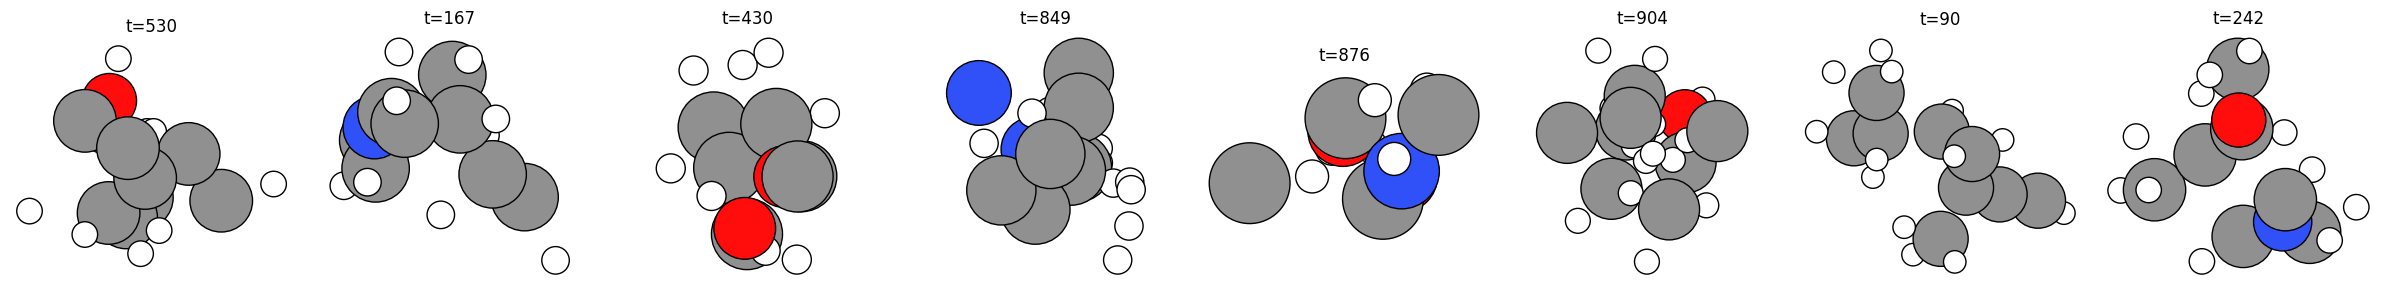

In [36]:
n_cols = 8
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    mask = batch[properties.idx_m] == i
    mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

    plot_atoms(mol, ax, rotation=("0x,0y,0z"))
    ax.axis("off")

    t = batch["t"][mask]
    t = t.unique()
    t = t * (noise_schedule.T-1)
    t = t.long().item()

    ax.set_title(f"t={t}")

plt.tight_layout()
plt.show()